# Using the NeuronBridge Python API

This notebook demonstrates how to use the NeuronBridge Python API.

In [1]:
# Some boilerplate code to make the notebook work
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

### Initialize the NeuronBridge client

This queries the NeuronBridge API to find the latest version and downloads the dynamic configuration. 

In [2]:
from neuronbridge import client
from neuronbridge.model import *
from typing import *
client = client.Client()

### Print client configuration information

In [3]:
print("Antomical areas:")
for area in client.config.anatomicalAreas:
    print(f"    {area}: {client.config.anatomicalAreas[area].alignmentSpace}")

print()
print("File stores:")
for store_key in client.config.stores.keys():
    print(f"    {store_key}")
    store = client.config.stores[store_key]
    print(f"        CDM files: {store.prefixes['CDM']}")
    print(f"        Match files: {store.prefixes['CDSResults']}")
    

Antomical areas:
    Brain: JRC2018_Unisex_20x_HR
    VNC: JRC2018_VNC_Unisex_40x_DS

File stores:
    fl:open_data:brain
        CDM files: https://s3.amazonaws.com/janelia-flylight-color-depth/
        Match files: https://s3.amazonaws.com/janelia-neuronbridge-data-prod/v3_2_1/metadata/cdsresults/
    fl:open_data:vnc
        CDM files: https://s3.amazonaws.com/janelia-flylight-color-depth/
        Match files: https://s3.amazonaws.com/janelia-neuronbridge-data-prod/v3_2_1/metadata/cdsresults/


### Retrieve the EM image for a given EM body id

id='2945073171639930891' libraryName='FlyEM_Hemibrain_v1.2.1' publishedName='hemibrain:v1.2.1:636798093' alignmentSpace='JRC2018_Unisex_20x_HR' anatomicalArea='Brain' gender=<Gender.female: 'f'> files=Files(store='fl:open_data:brain', CDM='JRC2018_Unisex_20x_HR/FlyEM_Hemibrain_v1.2.1/636798093-JRC2018_Unisex_20x_HR-CDM.png', CDMThumbnail='JRC2018_Unisex_20x_HR/FlyEM_Hemibrain_v1.2.1/636798093-JRC2018_Unisex_20x_HR-CDM.jpg', CDMInput=None, CDMMatch=None, CDMBest=None, CDMBestThumbnail=None, CDMSkel=None, SignalMip=None, SignalMipMasked=None, SignalMipMaskedSkel=None, Gal4Expression=None, VisuallyLosslessStack=None, AlignedBodySWC='JRC2018_Unisex_20x_HR/FlyEM_Hemibrain_v1.2.1/SWC/636798093.swc', AlignedBodyOBJ='JRC2018_Unisex_20x_HR/FlyEM_Hemibrain_v1.2.1/OBJ/636798093.obj', CDSResults='2945073171639930891.json', PPPMResults='2941779053884998178.json') terms=None type='EMImage' neuronType='LHPV5c1_a' neuronInstance='LHPV5c1_a_R'


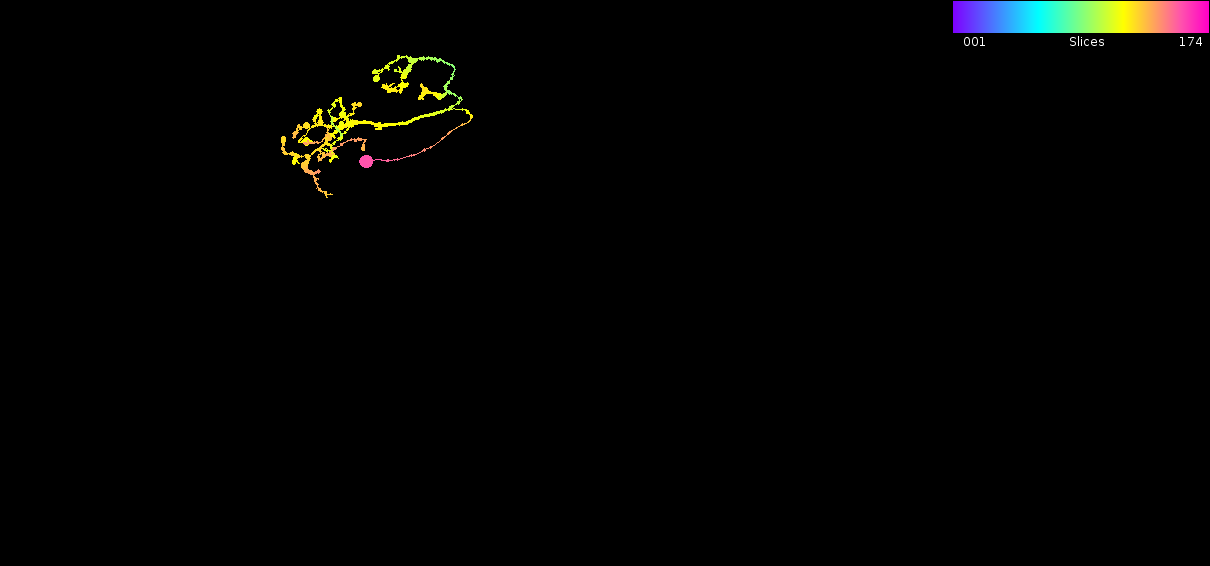

In [4]:
em_image = client.get_em_image(636798093) 
print(em_image)
client.get_cds_image(em_image)

### Retrieve the LM image for a given FlyLight line name

id='2798488256176455691' libraryName='FlyLight Split-GAL4 Drivers' publishedName='LH173' alignmentSpace='JRC2018_Unisex_20x_HR' anatomicalArea='Brain' gender=<Gender.female: 'f'> files=Files(store='fl:open_data:brain', CDM='JRC2018_Unisex_20x_HR/FlyLight_Split-GAL4_Drivers/LH173-20150828_24_F2-Split_GAL4-f-63x-brain-JRC2018_Unisex_20x_HR-CDM_2.png', CDMThumbnail='JRC2018_Unisex_20x_HR/FlyLight_Split-GAL4_Drivers/LH173-20150828_24_F2-Split_GAL4-f-63x-brain-JRC2018_Unisex_20x_HR-CDM_2.jpg', CDMInput=None, CDMMatch=None, CDMBest=None, CDMBestThumbnail=None, CDMSkel=None, SignalMip=None, SignalMipMasked=None, SignalMipMaskedSkel=None, Gal4Expression=None, VisuallyLosslessStack='Lateral+Horn+2019/LH173/LH173-20150828_24_F2-f-63x-brain-Split_GAL4-JRC2018_Unisex_20x_HR-aligned_stack.h5j', AlignedBodySWC=None, AlignedBodyOBJ=None, CDSResults='2798488256176455691.json', PPPMResults=None) terms=None type='LMImage' slideCode='20150828_24_F2' objective='63x' mountingProtocol='DPX PBS Mounting' cha

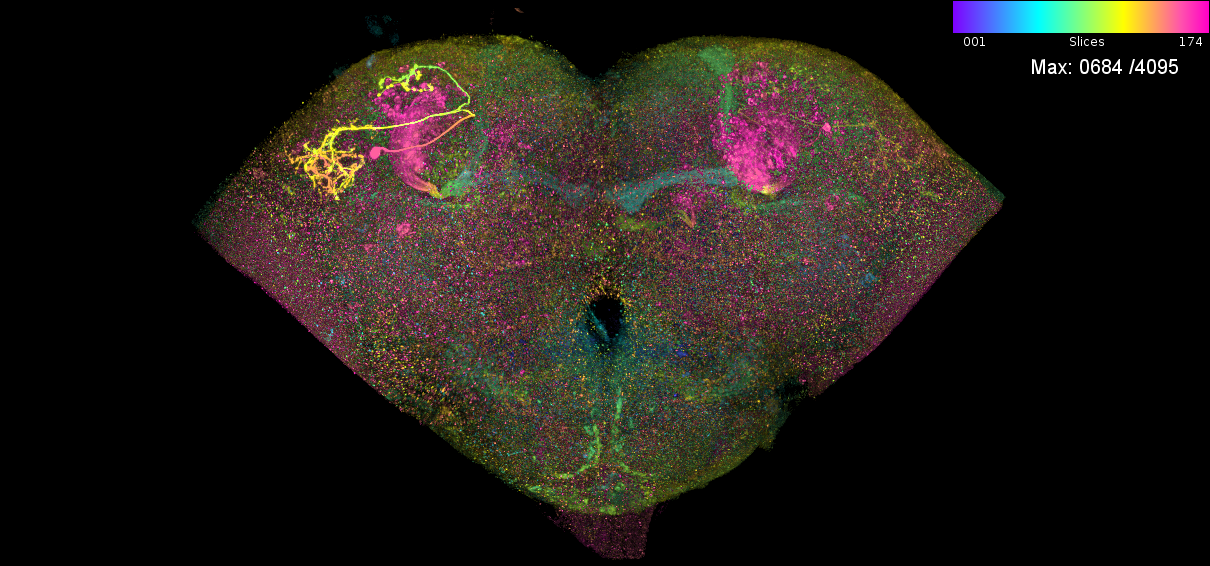

In [5]:
lm_images = client.get_lm_images('LH173')
lm_image = lm_images[0]
print(lm_image)
client.get_cds_image(lm_image)

### Retrieve matches for the EM body id

This retrieves both CDS and PPPM matches for the EM body id, and sorts them by score.

In [6]:
from neuronbridge import utils

cds_matches = client.get_cds_matches(em_image)
ppp_matches = client.get_ppp_matches(em_image)

cds_matches.sort(key=lambda m: m.normalizedScore, reverse=True)
ppp_matches.sort(key=lambda m: m.pppmRank)

print(f"CDS matches: {len(cds_matches)}")
print(f"PPP matches: {len(ppp_matches)}")

CDS matches: 13564
PPP matches: 150


### Intersection of CDS and PPPM matches

In [7]:
cds_names = utils.get_published_name_set(cds_matches)
ppp_names = utils.get_published_name_set(ppp_matches)

common = cds_names.intersection(ppp_names)
list(common)[:10]

['VT029514',
 'VT041884',
 'R53G11',
 'VT039518',
 'R24H03',
 'R19A04',
 'VT043162',
 'R17B08',
 'VT008691',
 'R26F09']

### Get ranks of lines found by both CDS and PPPM

We sort the common lines and retrieve their ranks in both CDS and PPPM results.

In [8]:
published_names = sorted(list(common))

cds_ranks = utils.get_ranks(cds_matches, published_names)
ppp_ranks = utils.get_ranks(ppp_matches, published_names)



### Create DataFrame 

The common lines are sorted by the mean rank of the line.

In [9]:
import pandas as pd
df = pd.DataFrame({'Name': published_names})
df['CDS Rank'] = df.apply(lambda row: cds_ranks[row['Name']], axis=1)
df['PPP Rank'] = df.apply(lambda row: ppp_ranks[row['Name']], axis=1)
df = df.loc[((df['CDS Rank']+df['PPP Rank'])/2.0).sort_values().index]
df

,Name,CDS Rank,PPP Rank
16,R89A01,6,7
18,VT002033,7,8
49,VT059225,4,17
28,VT023807,30,1
8,R28A10,36,4
9,R51H04,35,5
15,R74B08,13,43
51,VT063305,10,54
46,VT048350,80,6
44,VT046273,1,88


R89A01


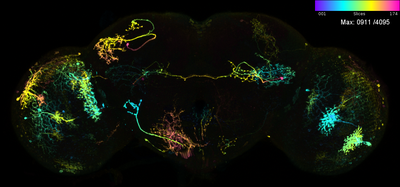

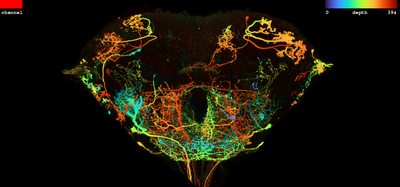

VT002033


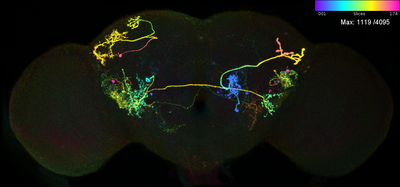

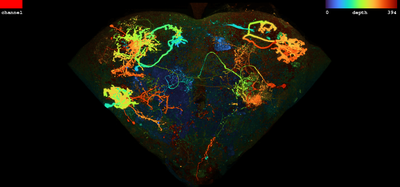

VT059225


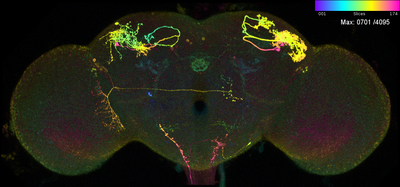

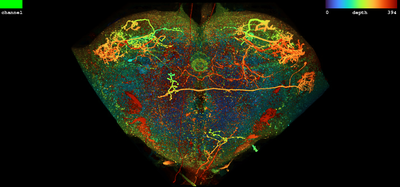

VT023807


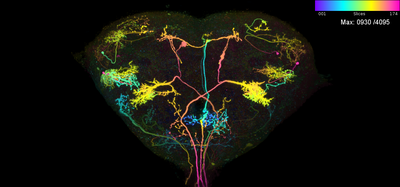

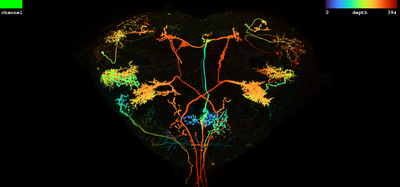

R28A10


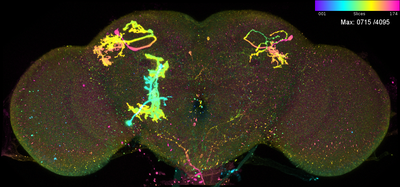

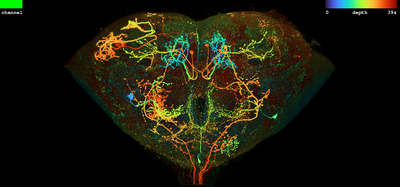

In [10]:
from IPython.display import display
from PIL.Image import Resampling
# Display top 5 lines
size = 400, 400
for name in df['Name'][:5]:
    cds_match = utils.get_first_match_for_name(cds_matches, name)
    cds_image = client.get_cds_image(cds_match, thumbnail=False)
    ppp_match = utils.get_first_match_for_name(ppp_matches, name)
    ppp_image = client.get_ppp_image(ppp_match, thumbnail=False)
    print(f"{name}")
    cds_image.thumbnail(size, Resampling.LANCZOS)
    ppp_image.thumbnail(size, Resampling.LANCZOS)
    display(cds_image, ppp_image)


### Overlay of EM and LM images

Some basic image processing using PIL to flatten and overlay the EM and LM images and show the 2D region in common. 

This could be improved by taking color depth into account when determining overlap. 

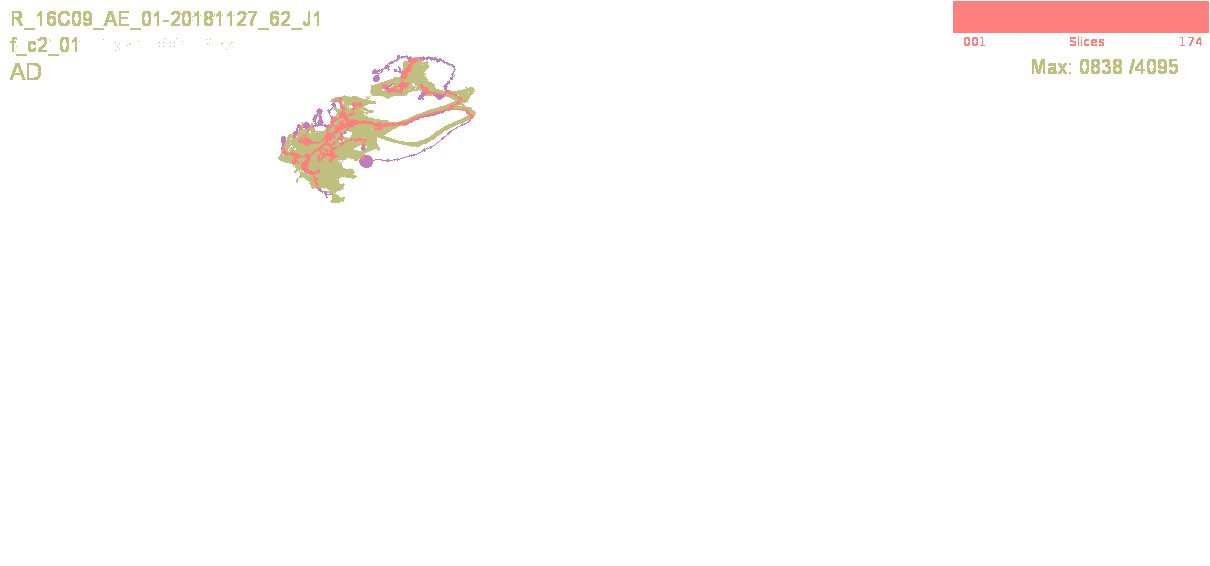

In [11]:
published_name = df['Name'][0]
cds_match = utils.get_first_match_for_name(cds_matches, published_name)
#print(cds_match)
cds = client.get_cds_image(cds_match)
match = client.get_match_searchable_image(cds_match)
target = client.get_target_searchable_image(cds_match)
#display(cds, match, target)

import numpy as np
def black_to_transparent(img, color):
    x = np.asarray(img.convert('RGBA')).copy()
    black_pixels = np.all(x == [0, 0, 0, 255], axis=-1)
    x[black_pixels] = [0, 0, 0, 0]
    x[~black_pixels] = color
    #x[:, :, 3] = ((x[:, :, :3] != 0).any(axis=2)).astype(np.uint8)
    return Image.fromarray(x.astype(np.uint8))

from PIL import Image, ImageEnhance

match = black_to_transparent(match, (255, 255, 0, 255))
target = black_to_transparent(target, (255, 0, 255, 255))
image = Image.blend(target, match, 0.5)
image = ImageEnhance.Brightness(image).enhance(1)
display(image)


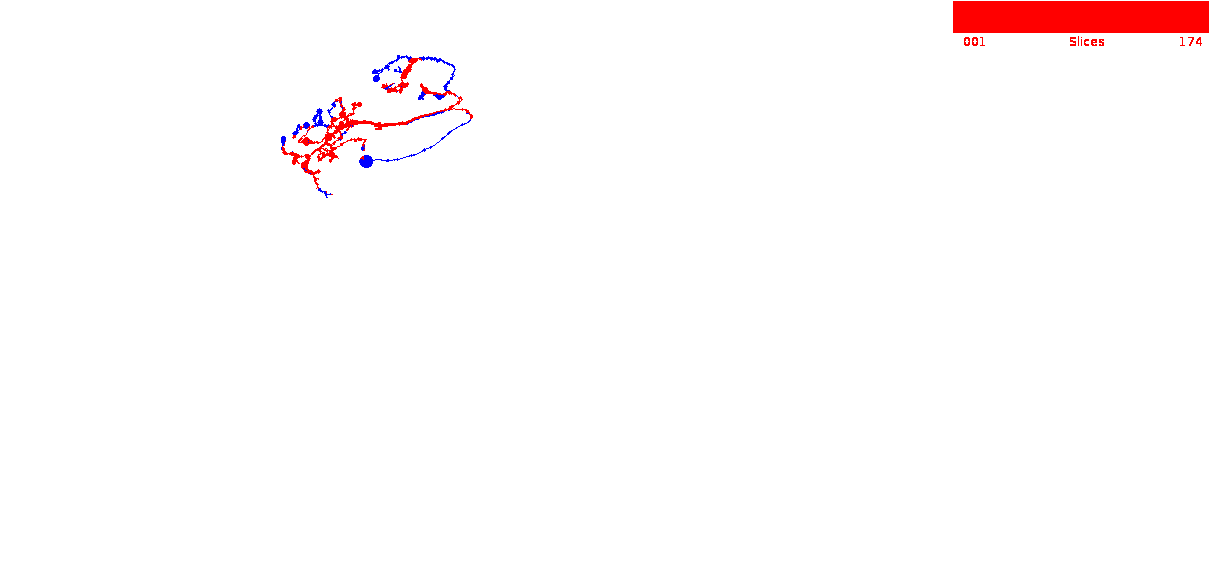

In [12]:
import blend_modes
import numpy

published_name = df['Name'][0]
cds_match = utils.get_first_match_for_name(cds_matches, published_name)
#print(cds_match)
cds = client.get_cds_image(cds_match)
match = client.get_match_searchable_image(cds_match)
target = client.get_target_searchable_image(cds_match)
#display(cds, match, target)

import numpy as np
def black_to_transparent(img, color):
    x = np.asarray(img.convert('RGBA')).copy()
    black_pixels = np.all(x == [0, 0, 0, 255], axis=-1)
    x[black_pixels] = [0, 0, 0, 0]
    x[~black_pixels] = color
    return Image.fromarray(x.astype(np.uint8))

from PIL import Image, ImageEnhance

match = black_to_transparent(match, (255, 0, 0, 255))
target = black_to_transparent(target, (0, 0, 255, 255))

#display(match)
#display(target)

match_float = numpy.array(match).astype(float)
target_float = numpy.array(target).astype(float)
blended_img_float = blend_modes.hard_light(target_float, match_float, 1.0)
blended_img = Image.fromarray(blended_img_float.astype(np.uint8))
display(blended_img)
